# Baseline computation

For each cell (folder) in our dataset directory, this notebook computes normalization constants with which we normalize fluorescent signals and forces.

### Zyxin variations
Cells express different amounts of total zyxin. To control for this variation, we normalize zyxin intensities (and analogous for other proteins) according to 

$$\hat{Z}^{\text{cell}}(t) =  \frac{ Z^{\text{cell}}(t)  - \mu^{\text{cell}}_{\text{out}} }{\mu^{\text{cell}}_{\text{in}} - \mu^{\text{cell}}_{\text{out}}} $$

$\mu^{\text{cell}}_{\text{out}}$ represents the mean zyxin signal measured _outside_ of the cell mask, while $\mu^{\text{cell}}_{\text{in}}$ measures the average zyxin intensity within the cell.
Averages are taken over time and space. 

### Force variations
Due to slight variations in substrate preparation, the forces measured on average (averaged across all cells) will differ from dataset to dataset.

To control for this, we normalize forces in each dataset by the average force exerted across all cells in that dataset. In this way, each dataset will have the same distribution of forces as expected (since they are prepared under identical conditions).

$$\hat{F}^{\text{cell}}(t) =  \frac{ F^{\text{cell}}(t) }{\mu_F^{\text{dataset}}} $$

$\mu_F^{\text{dataset}}$ represents the average force measured across all cells in the dataset to which "cell" belongs. Averages are taken over time and space. Over all our datasets, the average force is 267 Pa. Therefore, a measured force of 1 kPa will, in new units, have value ~4. We multiply these new units by 1/4 so that 1 kPa will be represented by 1 in the new units. Everywhere in the following, we report these new units as kPa. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.ndimage

import matplotlib as mpl
import torch
import torchvision #.transforms.function import affine
import time
import sys

root = '/project/vitelli/matthew/cell_force_prediction_public/'

if root not in sys.path: sys.path.append(root) # in root I have my utils module, from which I want to import things
from utils.nb_utils import *

%matplotlib inline

# Load data

In [2]:
data_root = os.path.join(root, 'data', 'TractionData_16kPa_WT')
subdirs = [x for x in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, x)) and ('cell' in x)]

print((np.asarray(subdirs)))
print(len(subdirs))

['myo_cell_7' 'pax_cell_5' 'pax_cell_2' 'myo_cell_6' 'myo_cell_1'
 '17_cell_3' '08_cell_1' 'myo_cell_0' '08_cell_3' '17_cell_2' '11_cell_1'
 'myo_cell_4' 'myo_cell_9' '11_cell_0' '17_cell_0' '17_cell_1' '10_cell_2'
 'myo_cell_5' '08_cell_4' '10_cell_3' 'pax_cell_4' 'myo_cell_8'
 '11_cell_4' '10_cell_4' '11_cell_2' 'myo_cell_2' '10_cell_1' 'pax_cell_1'
 'myo_cell_3' '17_cell_4' '08_cell_2']
31


# Plot cells

myo_cell_7
pax_cell_5
pax_cell_2
myo_cell_6
myo_cell_1
17_cell_3
08_cell_1


/project/vitelli/ml_venv/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


myo_cell_0
08_cell_3
17_cell_2
11_cell_1
myo_cell_4
myo_cell_9
11_cell_0
17_cell_0
17_cell_1
10_cell_2
myo_cell_5
08_cell_4
10_cell_3
pax_cell_4
myo_cell_8
11_cell_4
10_cell_4
11_cell_2
myo_cell_2
10_cell_1
pax_cell_1
myo_cell_3
17_cell_4
08_cell_2


/project/vitelli/ml_venv/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/project/vitelli/ml_venv/lib/python3.7/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/project/vitelli/ml_venv/lib/python3.7/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


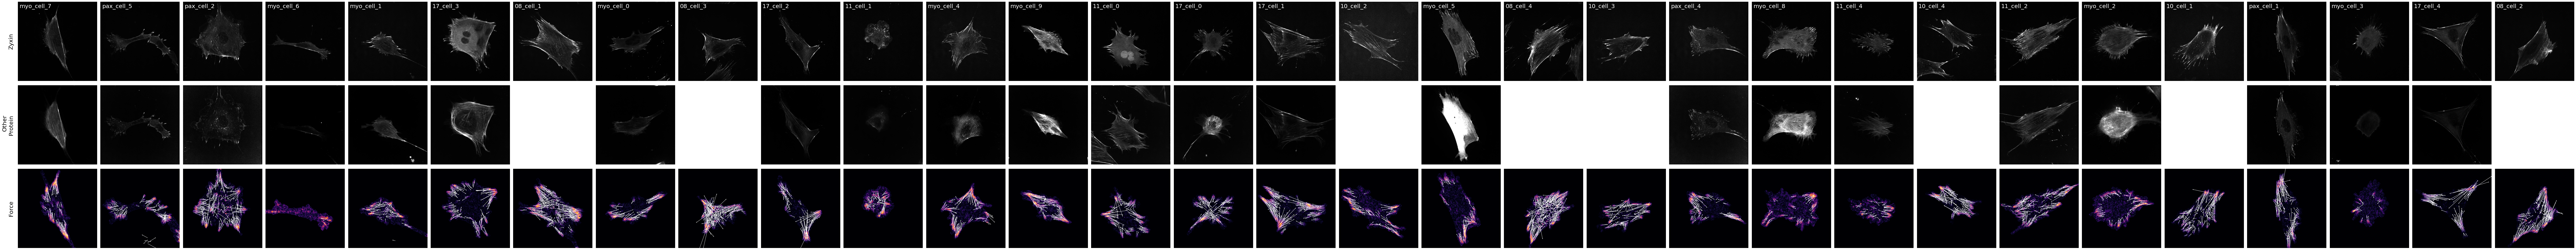

In [3]:
fig,ax = plt.subplots(3,len(subdirs),figsize=(len(subdirs)*4, 3*4), constrained_layout=1)

frame = 0
channels = [6,7]

for n,a in enumerate(ax.T):
    # Each item in the folders has channel structure [Displacement X, Displacement Y, Force X, Force Y, Mask, ForceMask, Zyxin, <other protein>]. 
    print(subdirs[n])
    im = np.load(os.path.join(data_root, subdirs[n], 'Disp_Trac_CellMask_ForceMask_Actin_%d.npy'%frame)) # has shape [7, H, W] where H, W are height and width of image
    im_ch0 = im[6]*1. # This is zyxin
    im_ch1 = im[7]*1. # This is other protein, where other = [actin, myosin, paxillin, mitochondria]
    mask = im[4]!=0
    mask = scipy.ndimage.binary_dilation(mask, iterations=20)#, structure=disk(r), iterations=1)
    im[:, mask==0] = 0

    f = im[[2,3]]
    mag = np.linalg.norm(f, axis=0)
    
    a[0].imshow(im_ch0/np.max(im_ch0), origin='lower', cmap='gray', vmax=0.5)
    a[1].imshow(im_ch1/np.max(im_ch1), origin='lower', cmap='gray', vmax=0.5)
    
    a[2].imshow(mag, origin='lower', cmap='inferno')
    a[2].quiver(*make_vector_field(*f, downsample=20, threshold=400), color='w', scale=1e4, width=0.003)
    
    a[0].text(0.02, 0.98, subdirs[n], color='w', fontsize=20, transform=a[0].transAxes, ha='left', va='top')
    
ax[0][0].text(-0.05, 0.5, 'Zyxin', transform=ax[0][0].transAxes, ha='right', va='center', rotation=90, fontsize=20)
ax[1][0].text(-0.05, 0.5, 'Other\nProtein', transform=ax[1][0].transAxes, ha='right', va='center', rotation=90, fontsize=20)
ax[2][0].text(-0.05, 0.5, 'Force', transform=ax[2][0].transAxes, ha='right', va='center', rotation=90, fontsize=20)

for a in ax.flat:
    a.axis('off')

In [9]:
celldirs = subdirs

mean_zyx = {}
mean_act = {}
mean_F = {}

for R, Cdirs in zip([data_root], [celldirs]):
    t0 = time.time()
    
    for i, cell in enumerate(Cdirs):
        celldir = os.path.join(R, cell)
        
        Zavg_out = 0
        Zavg_in = 0        
        Zstd_out = 0
        Zstd_in = 0
        
        Aavg_out = 0
        Aavg_in = 0        
        Astd_out = 0
        Astd_in = 0
        
        Fmax = []
        Favg = []        
        Fstd = [] 
        F99pct = []
        
        z_in, z_out = [], []
        a_in, a_out = [], []
                
        for t, file in enumerate(os.listdir(celldir)): # Unsorted list
            frame = np.load(os.path.join(celldir, file))
            act = frame[7]
            zyxin = frame[6]
            mask = frame[4]
            F = np.linalg.norm(frame[[2,3]], axis=0)

            Zavg_out += zyxin[mask==0].mean() / len(os.listdir(celldir)) # Average intensity outside of cell
            Zavg_in += zyxin[mask!=0].mean()  / len(os.listdir(celldir)) # Average intensity inside of cell
            Zstd_out += zyxin[mask==0].std() / len(os.listdir(celldir))
            Zstd_in += zyxin[mask!=0].std()  / len(os.listdir(celldir))
            
            Aavg_out += act[mask==0].mean() / len(os.listdir(celldir))
            Aavg_in += act[mask!=0].mean()  / len(os.listdir(celldir))
            Astd_out += act[mask==0].std() / len(os.listdir(celldir))
            Astd_in += act[mask!=0].std()  / len(os.listdir(celldir))
            
            Fmax.append(F.max())
            Favg.append(F.mean())      
            Fstd.append(F.std())
            F99pct.append(np.quantile(F.ravel(), 0.99))
            
            z_out.append(zyxin[mask==0].mean())
            z_in.append(zyxin[mask!=0].mean())
            
            a_out.append(act[mask==0].mean())
            a_in.append(act[mask!=0].mean())

        mean_zyx[cell] = [Zavg_out, Zavg_in, Zstd_out, Zstd_in, z_out, z_in]
        mean_act[cell] = [Aavg_out, Aavg_in, Astd_out, Astd_in, a_out, a_in]
        mean_F[cell] = [Fmax, Favg, Fstd, F99pct]
        
        print('Time for %u cell:\t %.2f'%(i+1, time.time()-t0))

Time for 1 cell:	 3.53
Time for 2 cell:	 7.59
Time for 3 cell:	 11.55
Time for 4 cell:	 15.38
Time for 5 cell:	 19.28
Time for 6 cell:	 23.70
Time for 7 cell:	 27.86
Time for 8 cell:	 33.15
Time for 9 cell:	 37.84
Time for 10 cell:	 41.87
Time for 11 cell:	 46.61
Time for 12 cell:	 51.01
Time for 13 cell:	 55.52
Time for 14 cell:	 59.48
Time for 15 cell:	 63.87
Time for 16 cell:	 68.31
Time for 17 cell:	 72.67
Time for 18 cell:	 76.73
Time for 19 cell:	 81.48
Time for 20 cell:	 85.69
Time for 21 cell:	 91.87
Time for 22 cell:	 97.51
Time for 23 cell:	 102.01
Time for 24 cell:	 106.96
Time for 25 cell:	 111.56
Time for 26 cell:	 116.12
Time for 27 cell:	 120.93
Time for 28 cell:	 125.77
Time for 29 cell:	 131.49
Time for 30 cell:	 136.01
Time for 31 cell:	 141.29


In [10]:
df = pd.DataFrame(columns=['cell', 'zyxin_lifetime_mean_outside', 'zyxin_lifetime_mean_inside', 'actin_lifetime_mean_outside', 'actin_lifetime_mean_inside'])

for n,cell in enumerate(celldirs):
    zx_out = mean_zyx[cell][0]
    zx_in = mean_zyx[cell][1]
    ac_out = mean_act[cell][0]
    ac_in = mean_act[cell][1]
    
    dict_append = {'cell': cell, 
                   'zyxin_lifetime_mean_outside': zx_out, # Average intensity outside of cell, averaged over entire time series
                   'zyxin_lifetime_mean_inside': zx_in,   # Average intensity inside of cell, averaged over entire time series
                   'actin_lifetime_mean_outside': ac_out, 
                   'actin_lifetime_mean_inside': ac_in}
    df = df.append(dict_append, ignore_index=1)

    
if input("Save?")=='save':
    df.to_csv(os.path.join(data_root, 'cell_mean_baselines.csv'))

df.head(20)

Save? save


cell  zyxin_lifetime_mean_outside  zyxin_lifetime_mean_inside  \
0   myo_cell_7                     8.604828                  149.042971   
1   pax_cell_5                    13.483160                  107.865877   
2   pax_cell_2                    12.871186                   76.133747   
3   myo_cell_6                     8.350864                   79.285169   
4   myo_cell_1                    10.759537                   52.137579   
5    17_cell_3                     8.746769                  186.016980   
6    08_cell_1                    19.077911                  125.741843   
7   myo_cell_0                    13.725387                  194.894092   
8    08_cell_3                    23.279466                  154.747226   
9    17_cell_2                     7.587803                   87.032938   
10   11_cell_1                     4.551186                   30.297869   
11  myo_cell_4                    10.159579                   41.178597   
12  myo_cell_9                     9.064306                  656.133748   
13   11_cell_0                     5.343723                  139.001300   
14   17_cell_0                     7.728254                  114.629982   
15   17_cell_1                     7.341417                   38.486210   
16   10_cell_2                     6.305236                   15.183401   
17  myo_cell_5                     9.014356                  160.660655   
18   08_cell_4                    29.809086                  258.989801   
19   10_cell_3                     6.322178                   24.781251   

    actin_lifetime_mean_outside  actin_lifetime_mean_inside  
0                      9.224547                  570.833085  
1                     11.252267                   41.712534  
2                      6.490439                    9.335153  
3                      6.539654                   94.807583  
4                     11.724144                  245.056516  
5                     32.319517                  512.709705  
6                      0.000000                    0.000000  
7                      8.808241                   67.193224  
8                      0.000000                    0.000000  
9                     31.241739                  585.215599  
10                    38.183907                  203.544609  
11                     7.134154                  134.536976  
12                     5.969592                  156.422812  
13                    63.854691                  314.891615  
14                    29.138141                  385.204802  
15                    32.502097                  301.430534  
16                     0.000000                    0.000000  
17                    30.501118                 3085.114925  
18                     0.000000                    0.000000  
19                     0.000000                    0.000000

# Plot adjusted trajectories

In [12]:
celldirs = subdirs

mean_zyx_adj = {}

for R, Cdirs in zip([data_root], [celldirs]):
    t0 = time.time()
    
    for i, cell in enumerate(Cdirs):
        celldir = os.path.join(R, cell)
                
        zx_out = mean_zyx[cell][0]
        zx_in = mean_zyx[cell][1]
        
        z_in_adj, z_out_adj = [], []
        
        for file in os.listdir(celldir):
            t = int(file.split('_')[-1].split('.')[0]) # split frame index from filename

            frame = np.load(os.path.join(celldir, file))
            act = frame[7]
            zyxin = frame[6]
            mask = frame[4]
            
            zyxin -= zx_out
            zyxin[zyxin<0] = 0
            zyxin /= (zx_in - zx_out)
            
            z_out_adj.append([t, zyxin[mask==0].mean()])
            z_in_adj.append([t, zyxin[mask!=0].mean()])
            

        mean_zyx_adj[cell] = np.asarray([z_out_adj, z_in_adj])
        
        print('Time for %u cell:\t %.2f'%(i+1, time.time()-t0))
        
        

Time for 1 cell:	 0.62
Time for 2 cell:	 1.25
Time for 3 cell:	 2.43
Time for 4 cell:	 5.89
Time for 5 cell:	 9.46
Time for 6 cell:	 12.23
Time for 7 cell:	 15.35
Time for 8 cell:	 18.41
Time for 9 cell:	 21.04
Time for 10 cell:	 23.92
Time for 11 cell:	 26.43
Time for 12 cell:	 29.20
Time for 13 cell:	 31.81
Time for 14 cell:	 34.02
Time for 15 cell:	 36.10
Time for 16 cell:	 38.22
Time for 17 cell:	 40.66
Time for 18 cell:	 42.60
Time for 19 cell:	 44.69
Time for 20 cell:	 46.68
Time for 21 cell:	 48.21
Time for 22 cell:	 49.73
Time for 23 cell:	 51.27
Time for 24 cell:	 52.75
Time for 25 cell:	 54.00
Time for 26 cell:	 55.36
Time for 27 cell:	 56.50
Time for 28 cell:	 57.49
Time for 29 cell:	 58.47
Time for 30 cell:	 59.15
Time for 31 cell:	 59.89


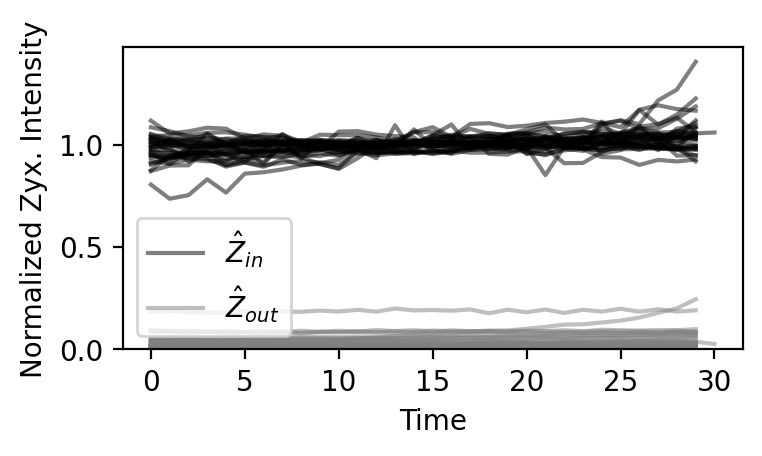

In [18]:
zyx_out_in_bycell = [[k, i] for k,i in mean_zyx_adj.items()]
cell_names = [d[0] for d in zyx_out_in_bycell]

time_bycell = np.asarray([d[1][0][:,0] for d in zyx_out_in_bycell])
zyx_data_out = np.asarray([d[1][0][:,1] for d in zyx_out_in_bycell])
zyx_data_in = np.asarray([d[1][1][:,1] for d in zyx_out_in_bycell])

fig,ax=plt.subplots(1,1,figsize=(4,2), dpi=200)

for i in range(len(cell_names)):
    T = time_bycell[i]
    Tsort = np.argsort(T)
    ax.plot(T[Tsort], zyx_data_in[i][Tsort], '-', color='k', alpha=0.5) # Average value of zyxin within cell, in NORMALIZED units
    ax.plot(T[Tsort], zyx_data_out[i][Tsort], '-', color='gray', alpha=0.5,) # Average value of zyxin outside cell, in NORMALIZED units
    

ax.plot([],[], '-', color='k', alpha=0.5, label='$ \\hat{Z}_{in}$') # Inside
ax.plot([],[], '-', color='gray', alpha=0.5, label='$ \\hat{Z}_{out}$') # Inside
    
   
ax.set_xlabel('Time')
ax.set_ylabel('Normalized Zyx. Intensity')#

ax.set_ylim(0, None)

ax.legend()#=20)
#ax.set_xlim(0,15)

# FORCE PLOTS

In [3]:
df = pd.read_csv(os.path.join(root, 'cell_force_baselines.csv'))


In [19]:
df = pd.DataFrame(columns=['cell', 'F_lifetime_mean_avg', 'F_lifetime_max_avg', 'F_lifetime_99pct_avg'])

                     
for n,cell in enumerate(celldirs):
    
    dict_append = {'cell': cell, 
                   'F_lifetime_mean_avg': np.asarray(mean_F[cell][1]).mean(), 
                   'F_lifetime_max_avg': np.asarray(mean_F[cell][0]).mean(),
                   'F_lifetime_99pct_avg': np.asarray(mean_F[cell][-1]).mean()}
    df = df.append(dict_append, ignore_index=1)

    

if input("Save?")=='save':
    df.to_csv(os.path.join(data_root, 'cell_force_baselines.csv'))


df.head(20)

Are you sure you want to save? save
Save? save


cell  F_lifetime_mean_avg  F_lifetime_max_avg  F_lifetime_99pct_avg
0   myo_cell_7           196.174408         2819.843018           1110.499776
1   pax_cell_5           210.733536         4223.568359            843.189461
2   pax_cell_2           368.812073         6085.923340           2273.513386
3   myo_cell_6           150.174469         1867.298218            575.267085
4   myo_cell_1           238.311188         3427.440430            976.525279
5    17_cell_3           267.259705         3805.843994           1174.799341
6    08_cell_1           406.663727         7338.364258           3328.721293
7   myo_cell_0           208.728958         4076.113037           1294.689606
8    08_cell_3           491.161255        13160.610352           3691.200727
9    17_cell_2           251.541000         4300.057617           1115.798263
10   11_cell_1           196.266083         3257.352783            994.255885
11  myo_cell_4           251.860352         3554.573242           1342.485031
12  myo_cell_9           187.493668         2540.297852           1097.269644
13   11_cell_0           227.573349         3598.199951           1410.131937
14   17_cell_0           256.071655         4046.814697           1016.533982
15   17_cell_1           284.694794         4847.888184           1563.601033
16   10_cell_2           308.642487         6271.265137           2405.924170
17  myo_cell_5           177.496796         2551.306885            767.863397
18   08_cell_4           528.666504         7327.455078           3638.003518
19   10_cell_3           277.249115         6390.663574           2657.298510

In [20]:
df['dataset'] = df.apply(lambda x: x['cell'].split('_')[0], axis=1)

In [27]:
df_dataset = df.copy()

df_avgs = df.groupby('dataset').mean()

cols = df_avgs.columns[:].values

df_avgs.reset_index(inplace=True)

groups = df_dataset.groupby('dataset')

for key, group in groups:
    x = np.repeat(df_avgs[df_avgs['dataset']==key][cols].values, 
                    len(df_dataset.loc[df_dataset['dataset']==key]),
                    axis=0)
    df_dataset.loc[df_dataset['dataset']==key, cols] = x




if input("Save?")=='save':
    df_dataset.to_csv(os.path.join(data_root, 'cell_force_baselines_bydataset.csv'))

    
print(df_dataset.mean())
df_dataset.head(20)


Save? 


F_lifetime_mean_avg      267.699875
F_lifetime_max_avg      5035.164484
F_lifetime_99pct_avg    1660.602072
dtype: float64


cell  F_lifetime_mean_avg  F_lifetime_max_avg  F_lifetime_99pct_avg  \
0   myo_cell_7           196.207277         3084.233850            976.383610   
1   pax_cell_5           283.279716         6382.162476           1519.507104   
2   pax_cell_2           283.279716         6382.162476           1519.507104   
3   myo_cell_6           196.207277         3084.233850            976.383610   
4   myo_cell_1           196.207277         3084.233850            976.383610   
5    17_cell_3           266.336246         4665.757422           1269.245076   
6    08_cell_1           443.632668         8686.291626           3405.797747   
7   myo_cell_0           196.207277         3084.233850            976.383610   
8    08_cell_3           443.632668         8686.291626           3405.797747   
9    17_cell_2           266.336246         4665.757422           1269.245076   
10   11_cell_1           224.307819         3684.781433           1185.406720   
11  myo_cell_4           196.207277         3084.233850            976.383610   
12  myo_cell_9           196.207277         3084.233850            976.383610   
13   11_cell_0           224.307819         3684.781433           1185.406720   
14   17_cell_0           266.336246         4665.757422           1269.245076   
15   17_cell_1           266.336246         4665.757422           1269.245076   
16   10_cell_2           300.015327         6726.507812           2731.439118   
17  myo_cell_5           196.207277         3084.233850            976.383610   
18   08_cell_4           443.632668         8686.291626           3405.797747   
19   10_cell_3           300.015327         6726.507812           2731.439118   

   dataset  
0      myo  
1      pax  
2      pax  
3      myo  
4      myo  
5       17  
6       08  
7      myo  
8       08  
9       17  
10      11  
11     myo  
12     myo  
13      11  
14      17  
15      17  
16      10  
17     myo  
18      08  
19      10